# LABORATORY SESSION - WEEK 13 

In [1]:
import pandas as pd
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from itertools import combinations
from collections import defaultdict
import random 

### Problem 

Implement and test how works chosen recommendation system. Results present in the form of infographic/presentation/raport.

### Solution 

In [2]:
# Specify the column names explicitly, since the dataset does not have a header
column_names = ['MovieID', 'YearOfRelease', 'Title']

# Try reading with error handling, specifying column names, and skipping bad lines
movie_titles_path = "data/movie_titles.csv"
movie_titles_df = pd.read_csv(movie_titles_path, 
                               encoding="ISO-8859-1", 
                               header=None, 
                               names=column_names,
                               on_bad_lines='skip')  # Skip lines with tokenization errors

# Display first few rows
print(movie_titles_df.head())
print()

# Check structure
print(movie_titles_df.info())
print()

# Check year distribution
print(movie_titles_df['YearOfRelease'].value_counts().sort_index())  
print()


   MovieID  YearOfRelease                         Title
0        1         2003.0               Dinosaur Planet
1        2         2004.0    Isle of Man TT 2004 Review
2        3         1997.0                     Character
3        4         1994.0  Paula Abdul's Get Up & Dance
4        5         2004.0      The Rise and Fall of ECW

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17434 entries, 0 to 17433
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MovieID        17434 non-null  int64  
 1   YearOfRelease  17427 non-null  float64
 2   Title          17434 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 408.7+ KB
None

YearOfRelease
1896.0       1
1909.0       1
1914.0       2
1915.0       5
1916.0       3
          ... 
2001.0    1168
2002.0    1284
2003.0    1243
2004.0    1412
2005.0     501
Name: count, Length: 94, dtype: int64



In [3]:
def load_combined_data(file_path):
    """
    Parses a Netflix Prize combined dataset file and loads it into a Pandas DataFrame.

    Parameters:
        file_path (str): Path to the Netflix dataset file.

    Returns:
        pd.DataFrame: A DataFrame containing ['MovieID', 'CustomerID', 'Rating', 'Date'].
    """
    data = []
    
    with open(file_path, "r") as f:
        movie_id = None  # Keep track of the current MovieID
        for line in f:
            line = line.strip()
            if line.endswith(":"):  # Detect MovieID lines
                movie_id = int(line[:-1])  # Remove colon and convert to integer
            else:  # Extract CustomerID, Rating, and Date
                customer_id, rating, date = line.split(",")
                data.append([movie_id, int(customer_id), int(rating), date])

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["MovieID", "CustomerID", "Rating", "Date"])
    
    # Convert Date column to datetime
    df["Date"] = pd.to_datetime(df["Date"])
    
    return df

# Example usage
file_paths = [
    "data/combined_data_1.txt",
    "data/combined_data_2.txt",
    "data/combined_data_3.txt",
    "data/combined_data_4.txt",
]

# CANNOT LOAD THE FULL DATASETS BEACOUSE IT IS TOO TIME EXPENSIVE 
# Load datasets
#combined_dfs = [load_combined_data(fp) for fp in file_paths]

# Concatenate all DataFrames
#df = pd.concat(combined_dfs, ignore_index=True)

# WE LOAD JUST THE FIRST COMBINED DATA 
combined_data_1_df = load_combined_data(file_paths[0])

In [4]:
# Display first few rows
print(combined_data_1_df.head())
print()

# Check structure
print(combined_data_1_df.info())
print()

# Check MovieID distribution
print(combined_data_1_df["MovieID"].value_counts())
print()

# Check CustomerID   distribution
print(combined_data_1_df["CustomerID"].value_counts())
print()

# Check rating distribution
print(combined_data_1_df["Rating"].value_counts())
print()

# Check Date distribution
print(combined_data_1_df["Date"].value_counts())
print()

   MovieID  CustomerID  Rating       Date
0        1     1488844       3 2005-09-06
1        1      822109       5 2005-05-13
2        1      885013       4 2005-10-19
3        1       30878       4 2005-12-26
4        1      823519       3 2004-05-03

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24053764 entries, 0 to 24053763
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   MovieID     int64         
 1   CustomerID  int64         
 2   Rating      int64         
 3   Date        datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 734.1 MB
None

MovieID
1905    193941
2152    162597
3860    160454
4432    156183
571     154832
         ...  
4294        44
915         43
3656        42
4338        39
4362        36
Name: count, Length: 4499, dtype: int64

CustomerID
305344     4467
387418     4422
2439493    4195
1664010    4019
2118461    3769
           ... 
2303975       1
1268014       1
534885        1
570658 

In [10]:
def add_movie_titles(interactions_df, movie_titles_df):
    """
    Adds a 'MovieTitle' column to the interactions dataframe.

    Args:
        interactions_df (pd.DataFrame): DataFrame containing 'CustomerID', 'MovieID', 'Rating'.
        movie_titles_df (pd.DataFrame): DataFrame containing 'MovieID' and 'Title'.

    Returns:
        pd.DataFrame: A new DataFrame with an additional 'MovieTitle' column.
    """
    # Merge on 'MovieID' to add movie titles
    enriched_df = interactions_df.merge(movie_titles_df[['MovieID', 'Title']], on="MovieID", how="left")
    
    # Rename the 'Title' column to 'MovieTitle' for clarity
    enriched_df = enriched_df.rename(columns={"Title": "MovieTitle"})

    return enriched_df

# Example usage
enriched_combined_data_1_df = add_movie_titles(combined_data_1_df, movie_titles_df)
print(enriched_combined_data_1_df.head())


   MovieID  CustomerID  Rating       Date       MovieTitle
0        1     1488844       3 2005-09-06  Dinosaur Planet
1        1      822109       5 2005-05-13  Dinosaur Planet
2        1      885013       4 2005-10-19  Dinosaur Planet
3        1       30878       4 2005-12-26  Dinosaur Planet
4        1      823519       3 2004-05-03  Dinosaur Planet



Top 5 for MovieID:
MovieID
1905    193941
2152    162597
3860    160454
4432    156183
571     154832
Name: count, dtype: int64

Top 5 for CustomerID:
CustomerID
305344     4467
387418     4422
2439493    4195
1664010    4019
2118461    3769
Name: count, dtype: int64

Top 5 for Rating:
Rating
4    8085741
3    6904181
5    5506583
2    2439073
1    1118186
Name: count, dtype: int64

Top 5 for Date:
Date
2005-01-19    180428
2005-04-06     84600
2005-06-01     56269
2005-06-27     55495
2005-05-31     55175
Name: count, dtype: int64

Top 5 for MovieTitle:
MovieTitle
Pirates of the Caribbean: The Curse of the Black Pearl    193941
What Women Want                                           162597
Bruce Almighty                                            160454
The Italian Job                                           156183
American Beauty                                           154832
Name: count, dtype: int64


C:\Users\39392\AppData\Local\Temp\ipykernel_20468\1085356718.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette="viridis")
C:\Users\39392\AppData\Local\Temp\ipykernel_20468\1085356718.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette="viridis")
C:\Users\39392\AppData\Local\Temp\ipykernel_20468\1085356718.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette="viridis")
C:\Users\39392\AppData\Local\Temp\ipykernel_20468\1085356718.

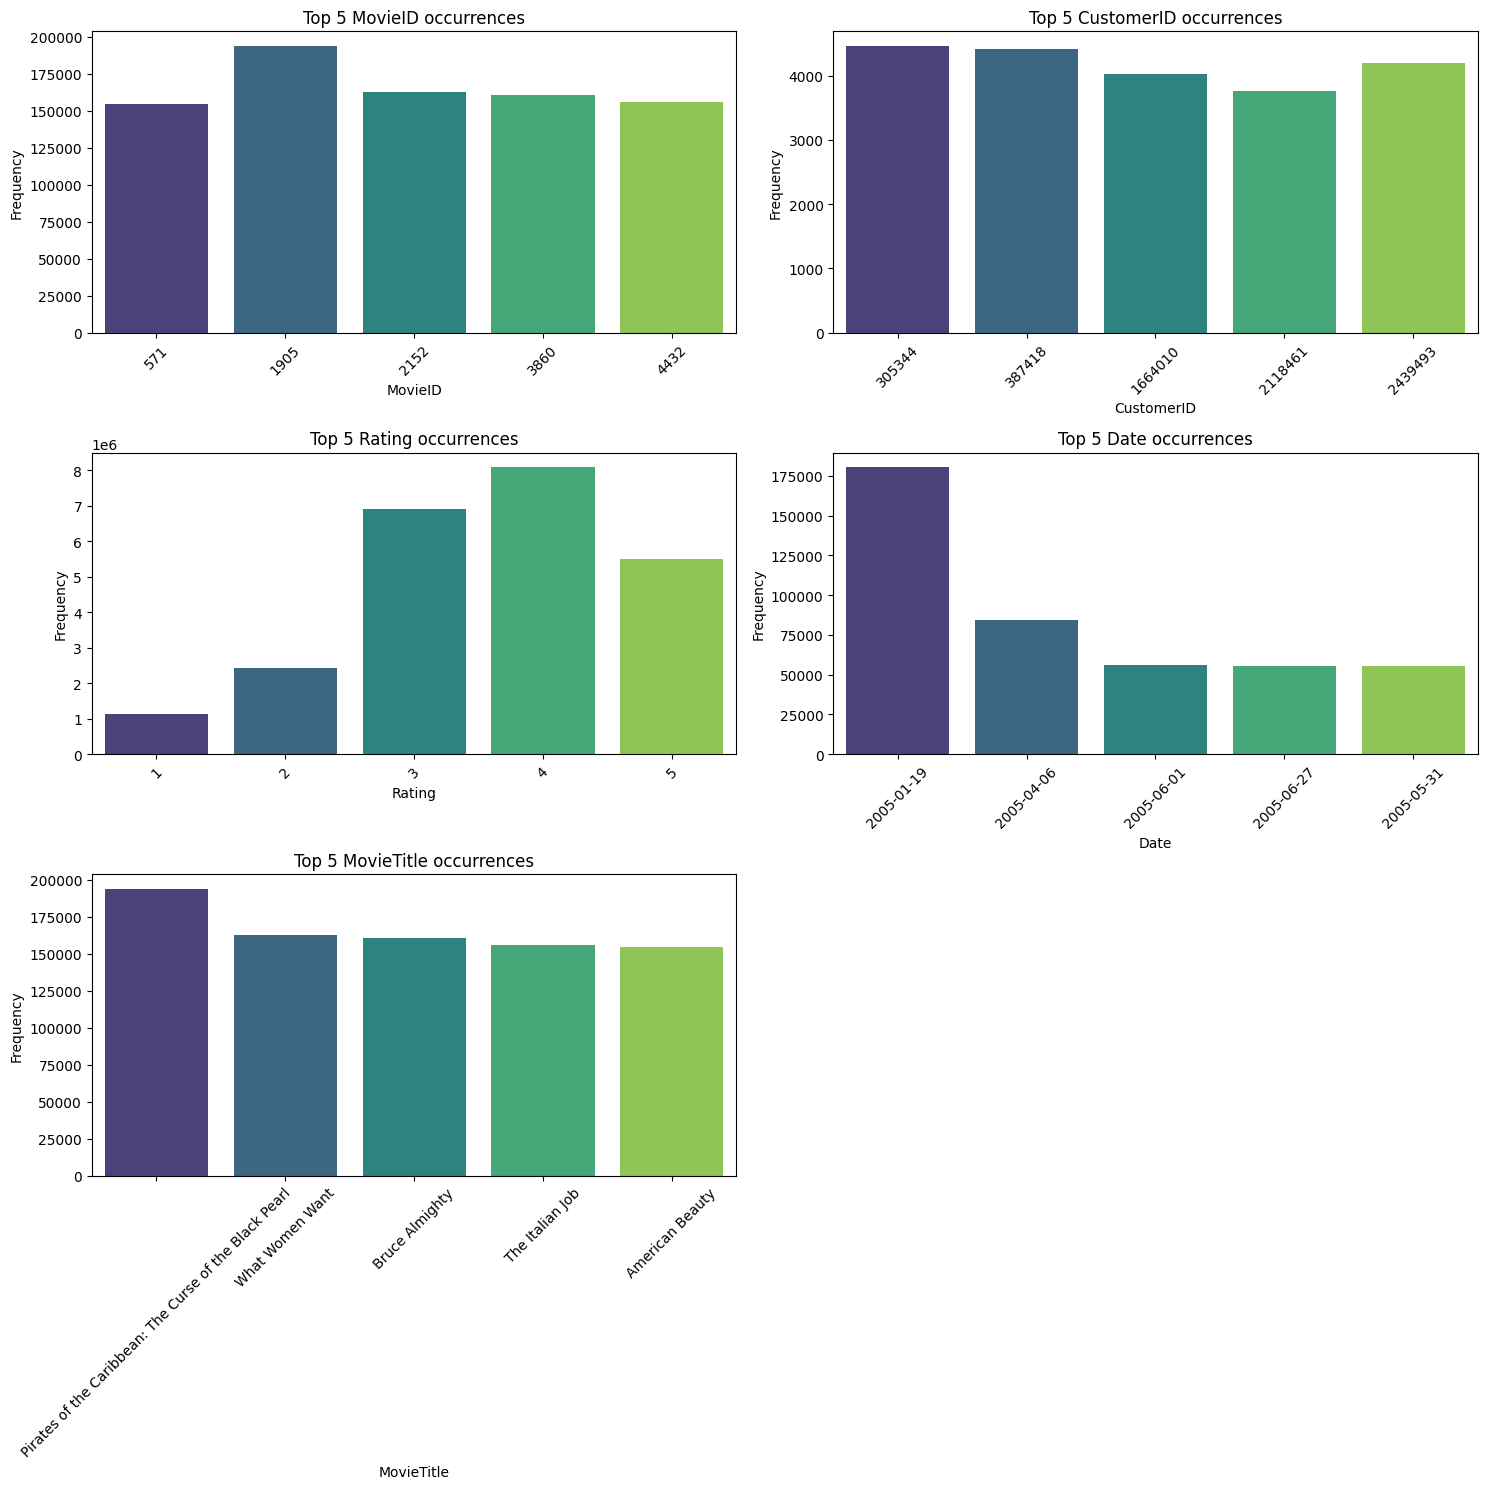

In [13]:
def extract_top_5(df):
    """
    Extracts the top 5 most frequent values for each attribute in the given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        dict: A dictionary containing the top 5 values for each column.
    """
    top_5_data = {}

    # Iterate over each column
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype == 'datetime64[ns]' or df[column].dtype == 'int64':
            top_5_data[column] = df[column].value_counts().head(5)

    return top_5_data

def plot_top_5(df):
    """
    Plots bar charts for the top 5 most frequent values of each attribute in the given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
    """
    top_5_data = extract_top_5(df)  # Get top 5 values for each column

    plt.figure(figsize=(15, 15))  # Set figure size

    # Iterate through the extracted data and create a subplot for each attribute
    for i, (column, data) in enumerate(top_5_data.items(), 1):
        plt.subplot(3, 2, i)  # Create a 2x2 grid of subplots
        sns.barplot(x=data.index, y=data.values, palette="viridis")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(f"Top 5 {column} occurrences")
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    plt.tight_layout()  # Adjust spacing
    plt.show()

# Apply the function to your dataset
top_5_results = extract_top_5(enriched_combined_data_1_df)

# Display results
for key, value in top_5_results.items():
    print(f"\nTop 5 for {key}:\n{value}")
    
# Apply the function to your dataset
plot_top_5(enriched_combined_data_1_df)

Randomly selected User ID: 1480257
Total movies watched: 223
          MovieID  CustomerID  Rating       Date            MovieTitle
16199977     3148     1480257       2 2001-09-14   The English Patient
6900599      1367     1480257       4 2001-09-14             The Piano
3139836       571     1480257       4 2002-04-24       American Beauty
7694288      1542     1480257       3 2002-04-24  Sleepless in Seattle
6581954      1297     1480257       4 2002-06-11          Agnes Browne


C:\Users\39392\AppData\Local\Temp\ipykernel_20468\1085356718.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette="viridis")
C:\Users\39392\AppData\Local\Temp\ipykernel_20468\1085356718.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette="viridis")
C:\Users\39392\AppData\Local\Temp\ipykernel_20468\1085356718.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette="viridis")
C:\Users\39392\AppData\Local\Temp\ipykernel_20468\1085356718.

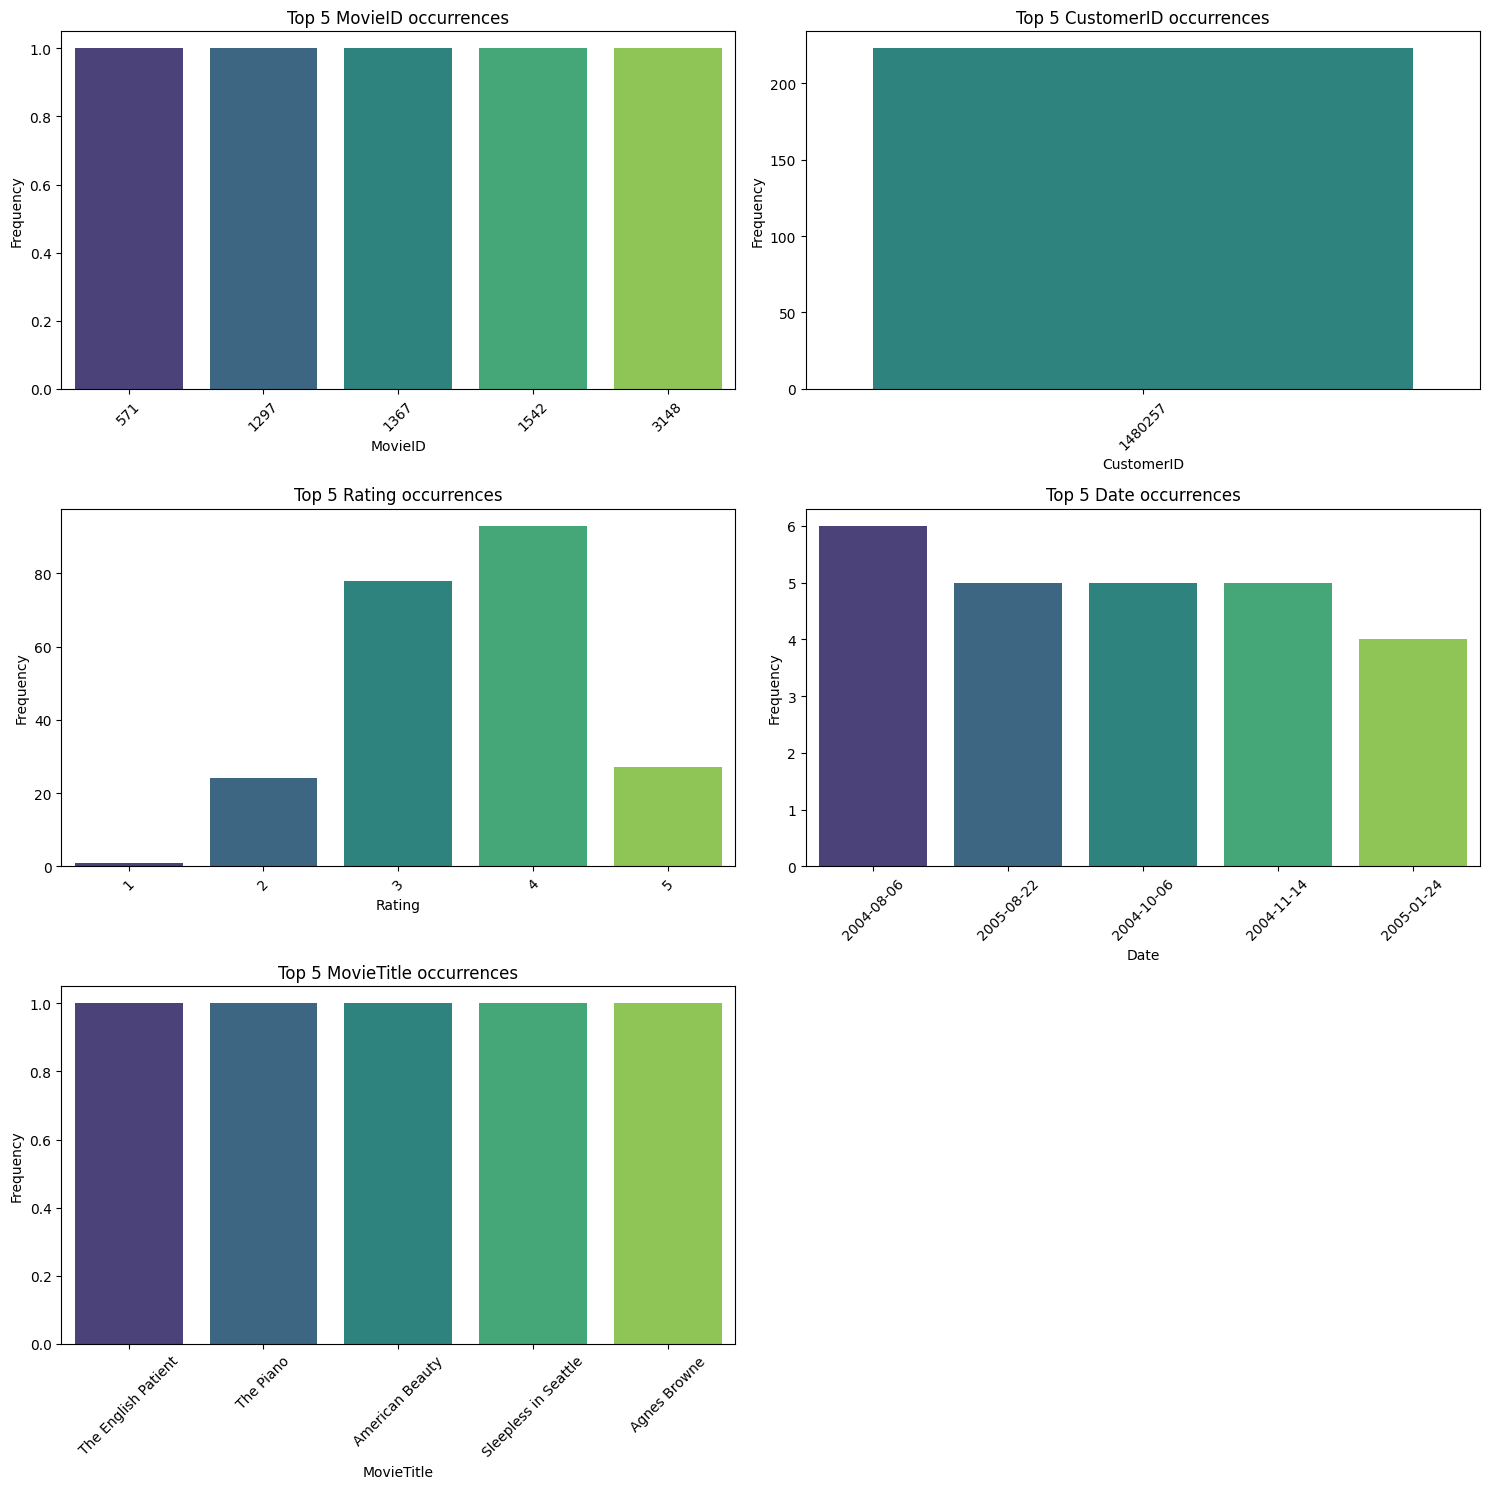

In [16]:
def extract_random_user_data(df):
    """
    Selects a random user from the dataset and extracts all movies they have seen,
    along with ratings, dates, and movie titles.

    Args:
        df (pd.DataFrame): The input DataFrame containing columns 
                           ['CustomerID', 'MovieID', 'Rating', 'Date', 'MovieTitle'].

    Returns:
        pd.DataFrame: A DataFrame containing all movies watched by the selected user.
        int: The randomly selected CustomerID.
    """
    # Select a random user
    random_user = np.random.choice(df["CustomerID"].unique())

    # Filter the dataset for this user
    user_df = df[df["CustomerID"] == random_user].copy()

    # Sort by date (optional)
    user_df = user_df.sort_values(by="Date", ascending=True)

    print(f"Randomly selected User ID: {random_user}")
    print(f"Total movies watched: {len(user_df)}")

    return user_df, random_user

# Example usage
random_user_df, selected_user = extract_random_user_data(enriched_combined_data_1_df)

# Display the dataset for the selected user
print(random_user_df.head())

# Example function to plot the top 5 movies watched by the user
plot_top_5(random_user_df)


In [17]:
def sample_rows(df, num_rows=100, random_state=None):
    """
    Returns a dataset containing a specified number of rows randomly sampled from the input DataFrame.

    Args:
        df (pd.DataFrame): The input dataset.
        num_rows (int): The number of rows to sample.
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A new dataset with the sampled rows.
    """
    return df.sample(n=num_rows, random_state=random_state).reset_index(drop=True)

# Example usage:
sampled_df = sample_rows(enriched_combined_data_1_df, num_rows=20, random_state=42)
print(sampled_df.head())

   MovieID  CustomerID  Rating       Date  \
0     3894     2260145       3 2005-01-19   
1     2960     1934293       3 2005-03-26   
2     2009     2559843       3 2004-02-09   
3      313     1197042       5 2001-08-21   
4     2680      900629       2 2004-07-07   

                              MovieTitle  
0                    Surviving Christmas  
1                        The Ladykillers  
2                The Talented Mr. Ripley  
3                         Pay It Forward  
4  Spy Kids 2: The Island of Lost Dreams  


In [ ]:
def plot_movie_frequency_and_user_activity(df):
    """
    Plots the movie frequency in the dataset and user activity (number of movies rated by each user).
    
    Args:
        df (pd.DataFrame): DataFrame with 'CustomerID', 'MovieID', and 'Rating'.
    """
    # Movie frequency: How many times each movie was rated
    movie_frequency = df.groupby('MovieTitle').size()

    # User activity: How many distinct movies each user has rated
    user_activity = df.groupby('CustomerID')['MovieTitle'].nunique()

    # Set up the figure and axes
    plt.figure(figsize=(14, 7))

    # Subplot 1: Movie frequency plot
    plt.subplot(1, 2, 1)
    movie_frequency.plot(kind='bar', color='blue', edgecolor='black', alpha=0.7, figsize=(10, 6))
    plt.title("Movie Rating Frequency Distribution")
    plt.xlabel("MovieTitle")
    plt.ylabel("Number of Ratings")
    plt.xticks(rotation=90)

    # Subplot 2: User activity plot (Number of movies each user has rated)
    plt.subplot(1, 2, 2)
    user_activity.plot(kind='bar', color='green', edgecolor='black', alpha=0.7, figsize=(10, 6))
    plt.title("User Activity: Number of Movies Rated")
    plt.xlabel("UserID")
    plt.ylabel("Number of Movies Rated")
    plt.xticks(rotation=90)

    # Display the plots
    plt.tight_layout()
    plt.show()

# Example usage:
plot_movie_frequency_and_user_activity(sampled_df)

Error in callback <function _draw_all_if_interactive at 0x000001537DEB08B0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [20]:
def build_bipartite_graph(df):
    """
    Constructs a bipartite user-movie graph.

    Args:
        df (pd.DataFrame): DataFrame with 'CustomerID', 'MovieID', and 'Rating'.

    Returns:
        G (networkx.Graph): The bipartite graph.
    """
    G = nx.Graph()

    # Add users and movies as nodes
    users = df["CustomerID"].unique()
    movies = df["MovieID"].unique()
    
    G.add_nodes_from(users, bipartite=0)  # Layer 0 (Users)
    G.add_nodes_from(movies, bipartite=1)  # Layer 1 (Movies)

    # Add edges with ratings as weights
    edges = list(zip(df["CustomerID"], df["MovieID"], df["Rating"]))
    G.add_weighted_edges_from(edges)

    return G

# Build and analyze the bipartite graph
G = build_bipartite_graph(sampled_df)

# Basic statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 39
Number of edges: 20


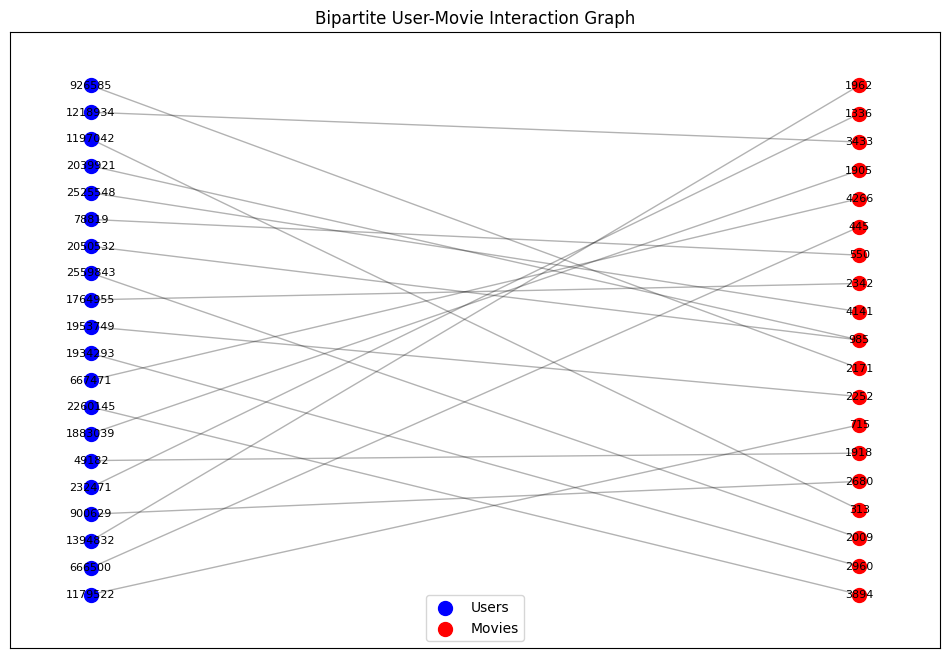

In [21]:
def plot_bipartite_graph(G):
    """
    Plots a bipartite user-movie graph.

    Args:
        G (networkx.Graph): A bipartite graph with users and movies.
    """
    # Separate nodes by type
    users = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
    movies = set(G.nodes) - users

    # Define positions using a bipartite layout
    pos = nx.bipartite_layout(G, users)

    plt.figure(figsize=(12, 8))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=users, node_color="blue", label="Users", node_size=100)
    nx.draw_networkx_nodes(G, pos, nodelist=movies, node_color="red", label="Movies", node_size=100)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Labels for a small subset (optional)
    if len(G.nodes) < 50:  
        nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Bipartite User-Movie Interaction Graph")
    plt.legend()
    plt.show()

# Example usage:
plot_bipartite_graph(G)

In [48]:
# sample a bigger df 
sampled_df = sample_rows(enriched_combined_data_1_df, num_rows=100000, random_state=42)
print(sampled_df.head())

# build a bigger User-Movie network
G = build_bipartite_graph(sampled_df)

# Basic statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

   MovieID  CustomerID  Rating       Date  \
0     3894     2260145       3 2005-01-19   
1     2960     1934293       3 2005-03-26   
2     2009     2559843       3 2004-02-09   
3      313     1197042       5 2001-08-21   
4     2680      900629       2 2004-07-07   

                              MovieTitle  
0                    Surviving Christmas  
1                        The Ladykillers  
2                The Talented Mr. Ripley  
3                         Pay It Forward  
4  Spy Kids 2: The Island of Lost Dreams  
Number of nodes: 80338
Number of edges: 100000


In [49]:
def project_user_graph(bipartite_graph, df, rating_similarity_threshold=0.5):
    """
    Projects a bipartite user-movie graph into a user-user similarity graph based on common movies and similar ratings.
    
    Args:
        bipartite_graph (networkx.Graph): The bipartite graph of users and movies.
        df (pd.DataFrame): DataFrame containing 'CustomerID', 'MovieID', and 'Rating'.
        rating_similarity_threshold (float): Threshold for considering ratings as similar (from 0 to 1).
        
    Returns:
        user_graph (networkx.Graph): The projected user-user graph with updated weights.
    """
    user_graph = nx.Graph()
    
    # Create a mapping of movies to users who rated them
    movie_to_users = defaultdict(list)
    for _, row in df.iterrows():
        movie_to_users[row["MovieID"]].append(row)

    # Iterate through movies and connect users who rated the same movie
    for movie_id, ratings in movie_to_users.items():
        for u1, u2 in combinations(ratings, 2):
            user1, rating1 = u1["CustomerID"], u1["Rating"]
            user2, rating2 = u2["CustomerID"], u2["Rating"]
            
            # Calculate the similarity in ratings (normalized absolute difference)
            rating_similarity = 1 - abs(rating1 - rating2) / 5  # Rating range from 0 to 5, so normalize
            
            # If similarity is above the threshold, include it in the weight calculation
            if rating_similarity >= rating_similarity_threshold:
                if user_graph.has_edge(user1, user2):
                    user_graph[user1][user2]["weight"] += rating_similarity  # Increase weight based on rating similarity
                else:
                    user_graph.add_edge(user1, user2, weight=rating_similarity)  # First shared movie with rating similarity
    
    return user_graph

# Project the user-movie graph to user-user similarity graph
user_user_graph = project_user_graph(G, sampled_df)

# Print some stats
print(f"Number of users: {user_user_graph.number_of_nodes()}")
print(f"Number of edges: {user_user_graph.number_of_edges()}")


Number of users: 76467
Number of edges: 10488514


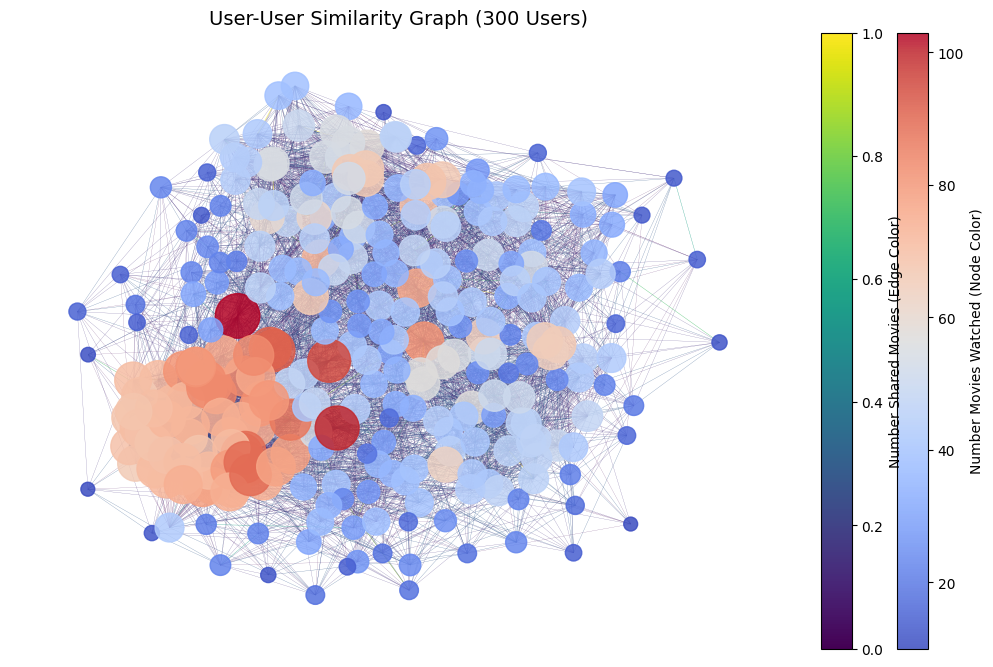

In [50]:
def plot_user_user_graph(G, top_n=100):
    """
    Plots the user-user similarity graph with:
    - Node color: Number of movies watched by each user.
    - Edge color: Number of shared movies.
    - Edge width: Strength of similarity.

    Args:
        G (networkx.Graph): The user-user graph.
        top_n (int): Number of top users to plot (to avoid overcrowding).
    """
    # Select top N most connected users
    if G.number_of_nodes() > top_n:
        degree_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
        top_users = {node for node, _ in degree_sorted[:top_n]}
        G = G.subgraph(top_users)

    fig, ax = plt.subplots(figsize=(12, 8))

    # Layout
    pos = nx.spring_layout(G, seed=42)  # Force-directed layout

    # Node color based on number of movies watched
    degrees = dict(G.degree)
    node_color = np.array([degrees[node] for node in G.nodes()])
    
    # Edge properties based on similarity weight
    edge_weights = np.array([d["weight"] for (_, _, d) in G.edges(data=True)])

    # Normalize edge colors to range between 0 and 1
    edge_color_norm = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-6)

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_color * 10, 
                                   node_color=node_color, cmap="coolwarm", alpha=0.85)

    # Draw edges with color mapping
    edges = nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_color_norm, 
                                   edge_cmap=plt.cm.viridis, width=edge_weights / 5, alpha=0.75)

    # Labels
    #nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, font_color="black")

    # Add colorbars
    cbar_nodes = fig.colorbar(nodes, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar_nodes.set_label("Number Movies Watched (Node Color)")

    cbar_edges = fig.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar_edges.set_label("Number Shared Movies (Edge Color)")

    # Title and formatting
    plt.title(f"User-User Similarity Graph ({top_n} Users)", fontsize=14)
    plt.axis("off")
    plt.show()

# Plot the updated user-user graph
plot_user_user_graph(user_user_graph, top_n=300)


Sampled User: 271019
Most similar user to 271019 is 2221430


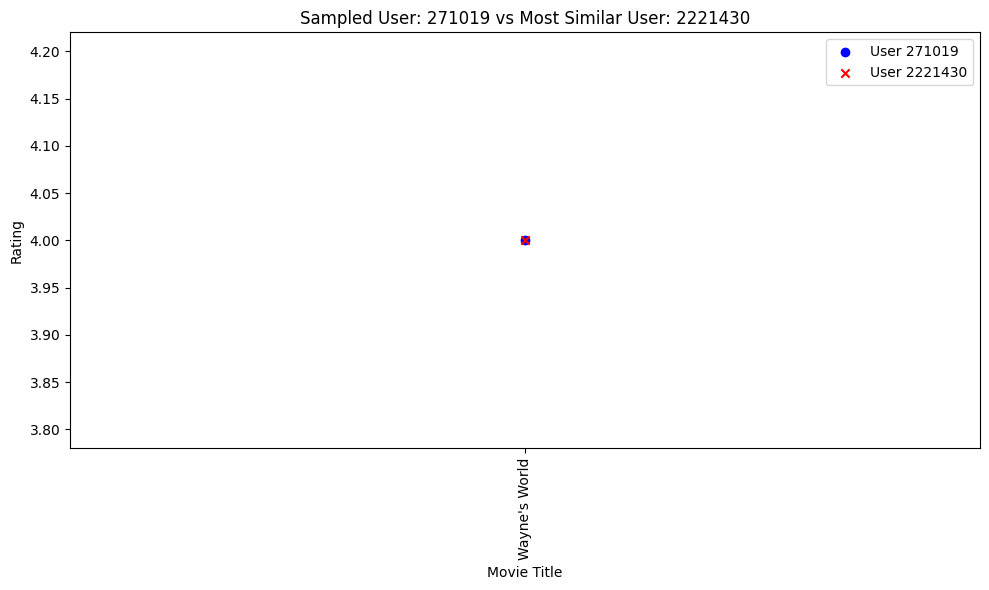


Common Movies Rated by Both Users:
   MovieID  Rating_271019   MovieTitle_x  Rating_2221430   MovieTitle_y
0     2470              4  Wayne's World               4  Wayne's World


In [124]:
def find_most_similar_user(G, df, sampled_user):
    """
    Finds the most similar user to a sampled user in the user-user similarity graph.
    """
    # Step 1: Find the most similar user to the sampled user
    similar_users = [(nbr, G[sampled_user][nbr]["weight"]) for nbr in G.neighbors(sampled_user)]
    if not similar_users:
        print(f"No similar users found for User {sampled_user}.")
        return None

    most_similar_user = max(similar_users, key=lambda x: x[1])[0]
    print(f"Most similar user to {sampled_user} is {most_similar_user}")
    return most_similar_user


def find_random_user_and_similar(G, df):
    """
    Samples a random user and finds the most similar user, then compares their movie preferences,
    including movie titles. Also plots the shared movies with corresponding ratings for both users.

    Args:
        G (networkx.Graph): The user-user similarity graph.
        df (pd.DataFrame): The original dataframe containing 'CustomerID', 'MovieID', 'Rating', 'Date', 'MovieTitle'.

    Returns:
        tuple: (user1, user2, common_movies_df)
    """
    # Step 1: Randomly select a user from the graph
    sampled_user = random.choice(list(G.nodes()))  # Select a random user
    print(f"Sampled User: {sampled_user}")

    # Step 2: Find the most similar user to the sampled user
    most_similar_user = find_most_similar_user(G, df, sampled_user)
    if most_similar_user is None:
        return None, None, pd.DataFrame()  # No similar user found

    # Step 3: Get their movie preferences
    sampled_user_movies = df[df["CustomerID"] == sampled_user][["MovieID", "Rating", "MovieTitle"]].rename(columns={"Rating": f"Rating_{sampled_user}"})
    similar_user_movies = df[df["CustomerID"] == most_similar_user][["MovieID", "Rating", "MovieTitle"]].rename(columns={"Rating": f"Rating_{most_similar_user}"})

    # Step 4: Merge to find common movies
    common_movies = pd.merge(sampled_user_movies, similar_user_movies, on="MovieID", how="inner")

    # Step 5: Plot shared movies with ratings for both users
    plt.figure(figsize=(10, 6))

    # Plot ratings for sampled user
    plt.scatter(common_movies["MovieTitle_x"], common_movies[f"Rating_{sampled_user}"], color='blue', label=f"User {sampled_user}", marker='o')
    
    # Plot ratings for most similar user
    plt.scatter(common_movies["MovieTitle_y"], common_movies[f"Rating_{most_similar_user}"], color='red', label=f"User {most_similar_user}", marker='x')

    # Add labels and title
    plt.title(f"Sampled User: {sampled_user} vs Most Similar User: {most_similar_user}")
    plt.xlabel("Movie Title")
    plt.ylabel("Rating")
    plt.xticks(rotation=90)  # Rotate movie titles for better readability
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

    return sampled_user, most_similar_user, common_movies

# Run function and get random user and their most similar user
user1, user2, common_movies_df = find_random_user_and_similar(user_user_graph, sampled_df)

# Display common movies with ratings
if not common_movies_df.empty:
    print("\nCommon Movies Rated by Both Users:")
    print(common_movies_df.head(10))
else:
    print("No common movies found for the sampled user.")


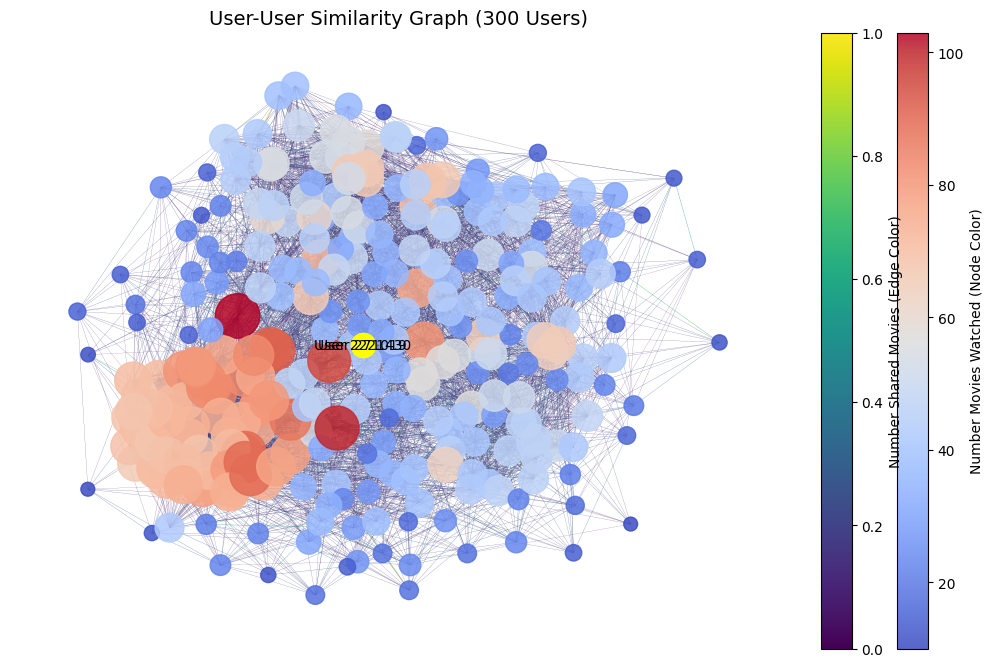

In [125]:
def plot_user_user_graph(G, user1, user2, top_n=100):
    """
    Plots the user-user similarity graph with:
    - Node color: Number of movies watched by each user.
    - Edge color: Number of shared movies.
    - Edge width: Strength of similarity.
    - Highlight the most similar users.

    Args:
        G (networkx.Graph): The user-user graph.
        user1 (int): First user to highlight.
        user2 (int): Second user to highlight.
        top_n (int): Number of top users to plot (to avoid overcrowding).
    """
    # Select top N most connected users
    if G.number_of_nodes() > top_n:
        degree_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
        top_users = {node for node, _ in degree_sorted[:top_n]}
        G = G.subgraph(top_users)

    fig, ax = plt.subplots(figsize=(12, 8))

    # Layout
    pos = nx.spring_layout(G, seed=42)  # Force-directed layout

    # Ensure the nodes user1 and user2 have positions in the layout
    pos[user1] = pos.get(user1, [0, 0])  # Default position if not found
    pos[user2] = pos.get(user2, [0, 0])  # Default position if not found

    # Node color based on number of movies watched
    degrees = dict(G.degree)
    node_color = np.array([degrees[node] for node in G.nodes()])
    
    # Edge properties based on similarity weight
    edge_weights = np.array([d["weight"] for (_, _, d) in G.edges(data=True)])

    # Normalize edge colors to range between 0 and 1
    edge_color_norm = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-6)

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_color * 10, 
                                   node_color=node_color, cmap="coolwarm", alpha=0.85)

    # Draw edges with color mapping
    edges = nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_color_norm, 
                                   edge_cmap=plt.cm.viridis, width=edge_weights / 5, alpha=0.75)

    # Highlight the most similar users
    nx.draw_networkx_nodes(G, pos, nodelist=[user1, user2], ax=ax, node_size=300, node_color="yellow", alpha=1.0)
    nx.draw_networkx_labels(G, pos, labels={user1: f'User {user1}', user2: f'User {user2}'}, ax=ax, font_size=10, font_color="black")

    # Add colorbars
    cbar_nodes = fig.colorbar(nodes, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar_nodes.set_label("Number Movies Watched (Node Color)")

    cbar_edges = fig.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar_edges.set_label("Number Shared Movies (Edge Color)")

    # Title and formatting
    plt.title(f"User-User Similarity Graph ({top_n} Users)", fontsize=14)
    plt.axis("off")
    plt.show()

# Plot the updated user-user graph with highlighted most similar users
plot_user_user_graph(user_user_graph, user1, user2, top_n=300)

Most similar users: 2271702 and 1369242 (Shared Movies: {'weight': 2.4000000000000004})
Columns in the merged dataframe: Index(['MovieID', 'Rating_2271702', 'MovieTitle_x', 'Rating_1369242',
       'MovieTitle_y'],
      dtype='object')


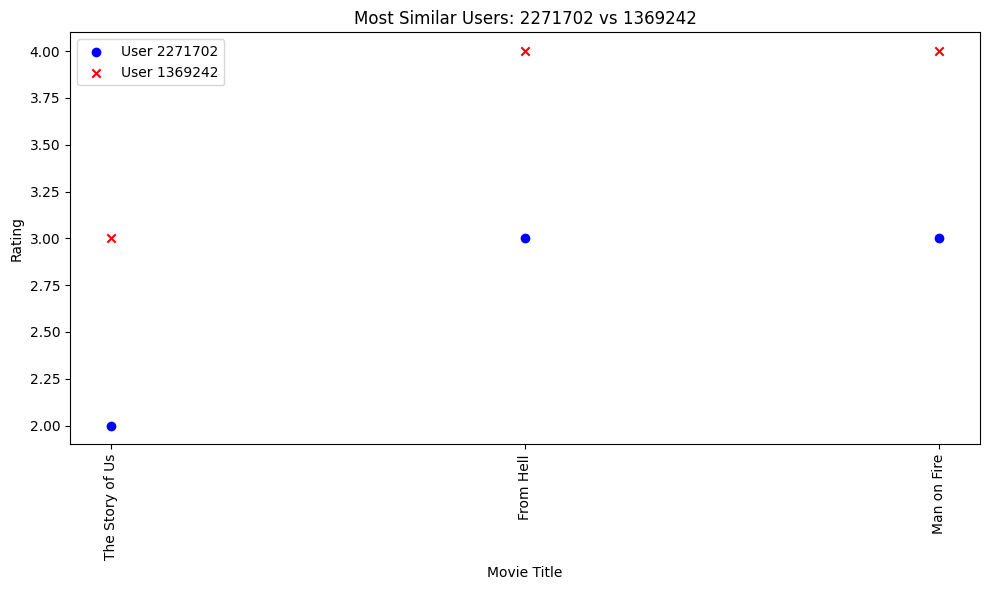


Common Movies Rated by Both Users:
   MovieID  Rating_2271702  Rating_1369242       MovieTitle
0     1955               2               3  The Story of Us
1     2734               3               4        From Hell
2     1220               3               4      Man on Fire


In [75]:
def find_most_similar_users(G, df):
    """
    Finds the most similar users in the user-user similarity graph and compares their movie preferences,
    including movie titles. Also plots the shared movies with corresponding ratings for both users.

    Args:
        G (networkx.Graph): The user-user similarity graph.
        df (pd.DataFrame): The original dataframe containing 'CustomerID', 'MovieID', 'Rating', 'Date', 'MovieTitle'.

    Returns:
        tuple: (user1, user2, common_movies_df)
    """
    # Step 1: Find the most similar users (max edge weight)
    most_similar_pair = max(G.edges(data=True), key=lambda x: x[2]['weight'])
    user1, user2, weight = most_similar_pair

    print(f"Most similar users: {user1} and {user2} (Shared Movies: {weight})")

    # Step 2: Get their movie preferences
    user1_movies = df[df["CustomerID"] == user1][["MovieID", "Rating", "MovieTitle"]].rename(columns={"Rating": f"Rating_{user1}"})
    user2_movies = df[df["CustomerID"] == user2][["MovieID", "Rating", "MovieTitle"]].rename(columns={"Rating": f"Rating_{user2}"})

    # Step 3: Merge to find common movies
    common_movies = pd.merge(user1_movies, user2_movies, on="MovieID", how="inner")

    # Debug: Check if the MovieTitle column exists
    print("Columns in the merged dataframe:", common_movies.columns)

    # Step 4: Drop one of the duplicate MovieTitle columns and rename
    common_movies['MovieTitle'] = common_movies['MovieTitle_x']  # Choose either MovieTitle_x or MovieTitle_y
    common_movies = common_movies.drop(columns=['MovieTitle_x', 'MovieTitle_y'])  # Drop redundant columns

    # Step 5: Plot shared movies with ratings for both users
    plt.figure(figsize=(10, 6))

    # Plot ratings for user1
    plt.scatter(common_movies["MovieTitle"], common_movies[f"Rating_{user1}"], color='blue', label=f"User {user1}", marker='o')
    
    # Plot ratings for user2
    plt.scatter(common_movies["MovieTitle"], common_movies[f"Rating_{user2}"], color='red', label=f"User {user2}", marker='x')

    # Add labels and title
    plt.title(f"Most Similar Users: {user1} vs {user2}")
    plt.xlabel("Movie Title")
    plt.ylabel("Rating")
    plt.xticks(rotation=90)  # Rotate movie titles for better readability
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

    return user1, user2, common_movies

# Run function and get most similar users
user1, user2, common_movies_df = find_most_similar_users(user_user_graph, sampled_df)

# Display common movies with ratings
print("\nCommon Movies Rated by Both Users:")
print(common_movies_df.head(10))


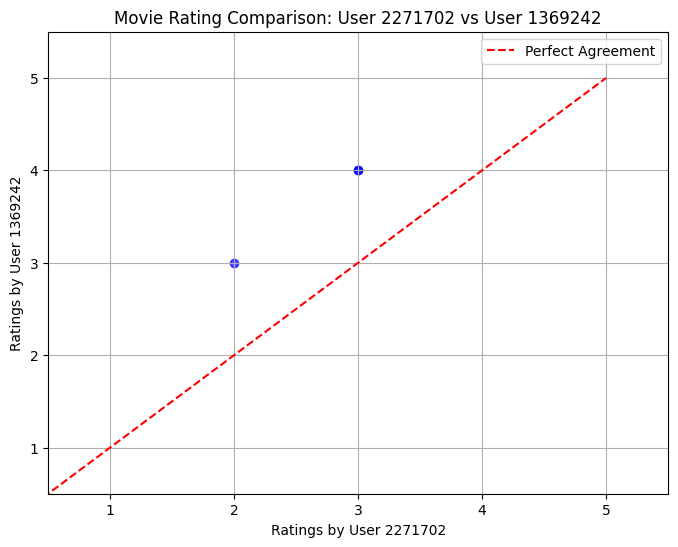

In [76]:
def plot_user_preferences(user1, user2, common_movies_df):
    """
    Plots a comparison of movie ratings between the two most similar users.

    Args:
        user1 (int): User ID of the first user.
        user2 (int): User ID of the second user.
        common_movies_df (pd.DataFrame): DataFrame containing shared movies and ratings.
    """
    plt.figure(figsize=(8, 6))

    # Scatter plot
    plt.scatter(common_movies_df[f"Rating_{user1}"], common_movies_df[f"Rating_{user2}"], alpha=0.7, color="blue")

    # Diagonal reference line (perfect agreement)
    plt.plot([0, 5], [0, 5], linestyle="--", color="red", label="Perfect Agreement")

    plt.xlabel(f"Ratings by User {user1}")
    plt.ylabel(f"Ratings by User {user2}")
    plt.title(f"Movie Rating Comparison: User {user1} vs User {user2}")
    plt.xlim(0.5, 5.5)
    plt.ylim(0.5, 5.5)
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot their movie preferences
plot_user_preferences(user1, user2, common_movies_df)


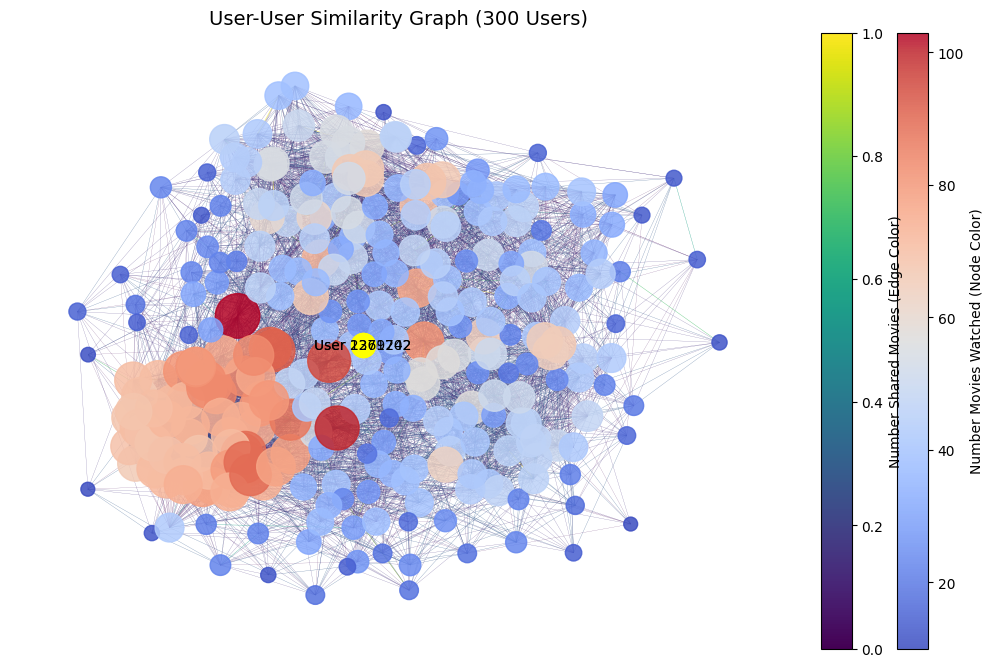

In [78]:
def plot_user_user_graph(G, user1, user2, top_n=100):
    """
    Plots the user-user similarity graph with:
    - Node color: Number of movies watched by each user.
    - Edge color: Number of shared movies.
    - Edge width: Strength of similarity.
    - Highlight the most similar users.

    Args:
        G (networkx.Graph): The user-user graph.
        user1 (int): First user to highlight.
        user2 (int): Second user to highlight.
        top_n (int): Number of top users to plot (to avoid overcrowding).
    """
    # Select top N most connected users
    if G.number_of_nodes() > top_n:
        degree_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
        top_users = {node for node, _ in degree_sorted[:top_n]}
        G = G.subgraph(top_users)

    fig, ax = plt.subplots(figsize=(12, 8))

    # Layout
    pos = nx.spring_layout(G, seed=42)  # Force-directed layout

    # Ensure the nodes user1 and user2 have positions in the layout
    pos[user1] = pos.get(user1, [0, 0])  # Default position if not found
    pos[user2] = pos.get(user2, [0, 0])  # Default position if not found

    # Node color based on number of movies watched
    degrees = dict(G.degree)
    node_color = np.array([degrees[node] for node in G.nodes()])
    
    # Edge properties based on similarity weight
    edge_weights = np.array([d["weight"] for (_, _, d) in G.edges(data=True)])

    # Normalize edge colors to range between 0 and 1
    edge_color_norm = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-6)

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_color * 10, 
                                   node_color=node_color, cmap="coolwarm", alpha=0.85)

    # Draw edges with color mapping
    edges = nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_color_norm, 
                                   edge_cmap=plt.cm.viridis, width=edge_weights / 5, alpha=0.75)

    # Highlight the most similar users
    nx.draw_networkx_nodes(G, pos, nodelist=[user1, user2], ax=ax, node_size=300, node_color="yellow", alpha=1.0)
    nx.draw_networkx_labels(G, pos, labels={user1: f'User {user1}', user2: f'User {user2}'}, ax=ax, font_size=10, font_color="black")

    # Add colorbars
    cbar_nodes = fig.colorbar(nodes, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar_nodes.set_label("Number Movies Watched (Node Color)")

    cbar_edges = fig.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar_edges.set_label("Number Shared Movies (Edge Color)")

    # Title and formatting
    plt.title(f"User-User Similarity Graph ({top_n} Users)", fontsize=14)
    plt.axis("off")
    plt.show()

# Plot the updated user-user graph with highlighted most similar users
plot_user_user_graph(user_user_graph, user1, user2, top_n=300)

Sampled User: 544779
Most similar user to 544779 is 1274580


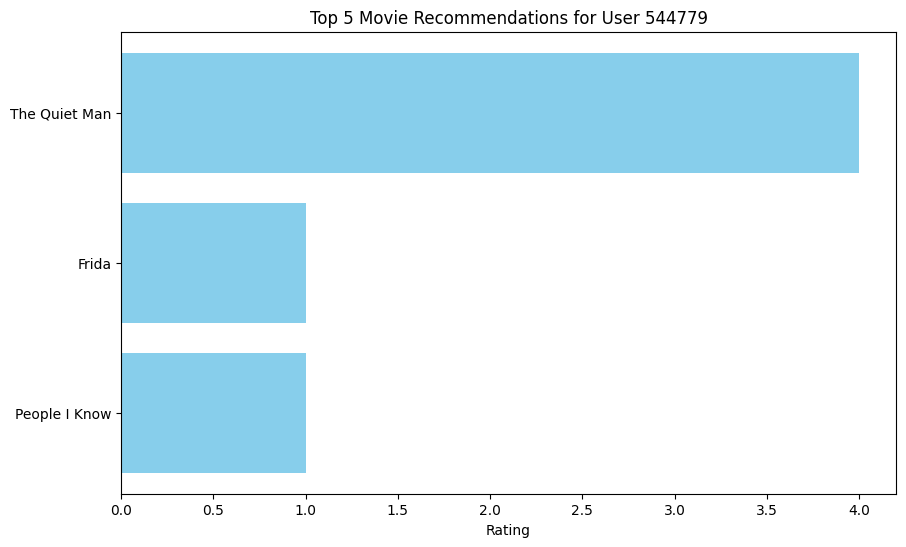


Recommended Movies:
       MovieID  Rating     MovieTitle
74204     3954       4  The Quiet Man
6673       482       1          Frida
55474     2269       1  People I Know


In [ ]:
def recommend_movies(G, df, sampled_user, num_recommendations=5):
    """
    Recommends movies to a sampled user based on their most similar user, including movie titles.
    Also, plots a bar chart for the recommendations.

    Args:
        G (networkx.Graph): The user-user similarity graph.
        df (pd.DataFrame): The original dataframe containing 'CustomerID', 'MovieID', 'Rating', 'Date', 'MovieTitle'.
        sampled_user (int): The user ID of the sampled user.
        num_recommendations (int): Number of movie recommendations.

    Returns:
        pd.DataFrame: Recommended movies with ratings from the similar user.
    """
    # Step 1: Get sampled user's watched movies
    sampled_user_movies = df[df["CustomerID"] == sampled_user]["MovieID"].unique()

    # Step 2: Find the most similar user to the sampled user
    similar_users = [(nbr, G[sampled_user][nbr]["weight"]) for nbr in G.neighbors(sampled_user)]
    if not similar_users:
        print(f"No similar users found for User {sampled_user}.")
        return pd.DataFrame()

    most_similar_user = max(similar_users, key=lambda x: x[1])[0]
    print(f"Most similar user to {sampled_user} is {most_similar_user}")

    # Step 3: Get the most similar user's watched movies and filter out movies already seen by the sampled user
    most_similar_user_movies = df[df["CustomerID"] == most_similar_user][["MovieID", "Rating", "MovieTitle"]]
    unseen_movies = most_similar_user_movies[~most_similar_user_movies["MovieID"].isin(sampled_user_movies)]

    # Step 4: Recommend top movies based on rating
    recommendations = unseen_movies.sort_values(by="Rating", ascending=False).head(num_recommendations)

    # Step 5: Plot recommendations as a bar chart
    if not recommendations.empty:
        plt.figure(figsize=(10, 6))
        plt.barh(recommendations["MovieTitle"], recommendations["Rating"], color='skyblue')
        plt.xlabel('Rating')
        plt.title(f"Top {num_recommendations} Movie Recommendations for User {sampled_user}")
        plt.gca().invert_yaxis()  # To display the highest rating on top
        plt.show()

    return recommendations

# Select a random user from the user-user graph
sampled_user = random.choice(list(user_user_graph.nodes))
print(f"Sampled User: {sampled_user}")

# Get recommendations
recommended_movies_df = recommend_movies(user_user_graph, sampled_df, sampled_user, num_recommendations=5)

# Display results
if not recommended_movies_df.empty:
    print("\nRecommended Movies:")
    print(recommended_movies_df)
else: 
    print("We have no recommendations for this user!")


In [8]:
def load_probe_data(file_path):
    """
    Parses the Netflix Prize probe dataset and loads it into a Pandas DataFrame.

    Parameters:
        file_path (str): Path to the probe dataset.

    Returns:
        pd.DataFrame: A DataFrame containing ['MovieID', 'UserID'].
    """
    data = []
    current_movie_id = None

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.endswith(":"):  # Movie ID line
                current_movie_id = int(line[:-1])  # Remove colon and convert to int
            else:  # User ID line
                user_id = int(line)
                data.append([current_movie_id, user_id])

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["MovieID", "UserID"])
    
    return df

# Example usage
probe_path = "data/probe.txt"
probe_df = load_probe_data(probe_path)

# Display first few rows
print(probe_df.head())
print()

# Check structure
print(probe_df.info())
print()

# Check unique movies
print(f"Unique movies: {probe_df['MovieID'].nunique()}")
print()

# Check unique users
print(f"Unique users: {probe_df['UserID'].nunique()}")
print()


   MovieID   UserID
0        1    30878
1        1  2647871
2        1  1283744
3        1  2488120
4        1   317050

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408395 entries, 0 to 1408394
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   MovieID  1408395 non-null  int64
 1   UserID   1408395 non-null  int64
dtypes: int64(2)
memory usage: 21.5 MB
None

Unique movies: 16938

Unique users: 462858



In [9]:
def load_qualifying_data(file_path):
    """
    Parses the Netflix Prize qualifying dataset and loads it into a Pandas DataFrame.

    Parameters:
        file_path (str): Path to the qualifying dataset.

    Returns:
        pd.DataFrame: A DataFrame containing ['MovieID', 'UserID', 'Date'].
    """
    data = []
    current_movie_id = None

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.endswith(":"):  # Movie ID line
                current_movie_id = int(line[:-1])  # Remove colon and convert to int
            else:  # User ID, Date line
                user_id, date = line.split(",")
                data.append([current_movie_id, int(user_id), date])

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["MovieID", "UserID", "Date"])
    
    return df

# Example usage
qualifying_path = "data/qualifying.txt"
qualifying_df = load_qualifying_data(qualifying_path)

# Display first few rows
print(qualifying_df.head())
print()

# Check structure
print(qualifying_df.info())
print()

# Check unique movies
print(f"Unique movies: {qualifying_df['MovieID'].nunique()}")
print()

# Check unique users
print(f"Unique users: {qualifying_df['UserID'].nunique()}")
print()

   MovieID   UserID        Date
0        1  1046323  2005-12-19
1        1  1080030  2005-12-23
2        1  1830096  2005-03-14
3        1   368059  2005-05-26
4        1   802003  2005-11-07

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817131 entries, 0 to 2817130
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   MovieID  int64 
 1   UserID   int64 
 2   Date     object
dtypes: int64(2), object(1)
memory usage: 64.5+ MB
None

Unique movies: 17470

Unique users: 478615

